In [74]:
import os
import pytorch_lightning as pl
import torch 
from torch import nn
from torch import utils

from torchaudio import datasets, transforms
from torchvision import models

from transformers import T5Tokenizer, T5ForConditionalGeneration
import nltk
import numpy as np


In [3]:
dataset = datasets.LIBRISPEECH(
                            root="./",
                            url="dev-clean",
                            folder_in_archive="LibriSpeech",
                            download=False
                            )

In [4]:
dataset[0]

(tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]]),
 16000,
 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
 1272,
 128104,
 0)

In [4]:
wav_lengths = []
for value in dataset:
    wav_lengths.append(value[0].shape[1])

In [5]:
max(wav_lengths)

522320

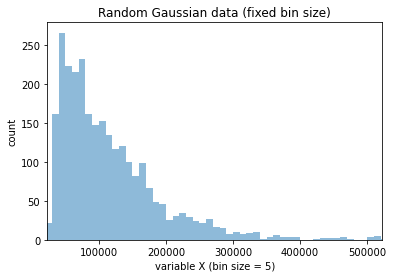

In [6]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = np.array(wav_lengths)

# fixed bin size
bins = np.arange(0, 600000, 10000) # fixed bin size

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()


In [6]:
encoder = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1).features
decoder = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")
transform = transforms.MelSpectrogram(16000, n_fft=800)

/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [7]:
class TokenizedDataset(utils.data.Dataset):
    def __init__(self, raw_dataset, tokenizer, max_len=300000):
        self.raw_dataset = raw_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.raw_dataset)
    
    def __getitem__(self, idx):
        data = self.raw_dataset[idx]
        x = data[0]
        y = data[2]

        y = self.tokenizer.encode_plus(
                                        text=y,  # the sentence to be encoded
                                        add_special_tokens=True,  # Add [CLS] and [SEP]
                                        max_length=512,  # maximum length of a sentence
                                        padding="max_length",  # Add [PAD]s
                                        return_tensors='pt',  # ask the function to return PyTorch tensors
                                        truncation=True,
                                    )

        if x.shape[1] < self.max_len:
            pad_x = torch.zeros((x.shape[0], self.max_len))
            pad_x[:, :x.size(1)] = x
            x = pad_x
        else:
            x = x[:,0:(self.max_len)]

        
        #return x,y["input_ids"], y["attention_mask"]
        return x,y["input_ids"].squeeze(), y["attention_mask"].squeeze()

mydataset = TokenizedDataset(dataset, tokenizer)
mydataset[0][0].shape

torch.Size([1, 400000])

In [8]:
mydataset = TokenizedDataset(dataset, tokenizer)

train_set, val_set, test_set = utils.data.random_split(mydataset, [0.6, 0.2, 0.2])

#train_loader = utils.data.DataLoader(train_set, batch_size=2, num_workers=os.cpu_count())
#val_loader = utils.data.DataLoader(val_set, batch_size=2, num_workers=os.cpu_count())
#test_set = utils.data.DataLoader(test_set, batch_size=2, num_workers=os.cpu_count())

train_loader = utils.data.DataLoader(train_set, batch_size=2)
val_loader = utils.data.DataLoader(val_set, batch_size=2)
test_set = utils.data.DataLoader(test_set, batch_size=2)


In [78]:
class EncoderDecoder(pl.LightningModule):
    def __init__(self, encoder, decoder, transform, tokenizer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transform = transform
        self.tokenizer = tokenizer

        random_input = torch.rand((1,90000))
        random_spectrogram = self.transform(random_input)
        random_spectrogram = random_spectrogram.repeat(1,3,1,1)
        random_extracted_features = self.encoder(random_spectrogram)
        self.n_filters = random_extracted_features.shape[1]


    def forward(self, *args):

        x = args[0]
        out = self.transform(x)
        out = out.repeat(1, 3, 1, 1)
        out = self.encoder(out)
        out = out.permute(0, 2, 3, 1)
        out = out.reshape(-1, int(out.shape[1] * out.shape[2] * out.shape[3]/ self.decoder.config.d_model), self.decoder.config.d_model )

        if len(args) > 2:
            y = args[1]
            mask = args[2]
            out = self.decoder(inputs_embeds=out, labels=y,return_dict=True, decoder_attention_mask=mask)

        return out

    def generate(self, 
                 x,
                 mask,
                 max_length=1024,
                 min_length=0,
                 num_beams=5,
                 no_repeat_ngram_size=2,
                 num_return_sequences=1,
                 early_stopping=True,
                 decode=False):

        out = self.forward(x)
        out = self.decoder.generate(inputs_embeds=out,
                                    max_length=max_length,
                                    min_length=min_length,
                                    num_beams=num_beams, 
                                    no_repeat_ngram_size=no_repeat_ngram_size,
                                    num_return_sequences=num_return_sequences, 
                                    early_stopping=early_stopping,
                                    decoder_attention_mask=mask
                                    )
        
        if decode:
            out = self.translate_encoded_ids(out)

        return out 

    def translate_encoded_ids(self, encoded_ids_list):
        phrases = []
        for encoded_ids in encoded_ids_list:
            decoded_ids = self.tokenizer.decode(encoded_ids, skip_special_tokens=True)
            phrases.append(decoded_ids)
        return phrases

    def training_step(self, train_batch, batch_idx):
        x, y, mask = train_batch
        out  = self.forward(x, y, mask)
        loss = out.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y, mask = val_batch
        decoded_y = self.translate_encoded_ids(y)
        
        gen_pred = self.generate(x, mask)
        decoded_gen_pred = self.translate_encoded_ids(gen_pred)

        scores = []
        for string_comb in zip(decoded_y, decoded_gen_pred):
            print(string_comb[0], string_comb[1])
            score = levensthein_distance(string_comb[0], string_comb[1])
            scores.append(score)

        scores = np.array(scores)
        batch_score = scores.mean()

        return batch_score

    def levensthein_distance(self, str_1, str_2):
        str_1 = str_1.upper()
        str_2 = str_2.upper()
        dist = (1 - nltk.edit_distance(str_2, str_1)/max(len(str_1), len(str_2)))
        return dist


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer


      




        

In [79]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)

batch_x, batch_y, mask = next(iter(train_loader))

gen_phrase = model.generate(batch_x, mask, decode=True)


In [82]:
model.validation_step((batch_x, batch_y, mask), 1)

ANOTHER FLOGGING TO MORROW SAID HE GRUMBLINGLY . e s d'un l'ad an't en  - c o m i u v y p r g h f b j k w z x q, à re er...! ; il é / 0 % Y & X :? ) – if he ’s the
CAN YOU REMEMBER WHAT HEPSEY TOLD US AND CALL THEM POOR LONG SUFFERIN CREETERS NAMES . ss -- e,  a d i ''  and  in in  to en l  t n o re :...  is  on er  de r u c  ( )  of f  the / g ;  for m ing  at!  au  be  as  with & y b ly th in  will  an  or


0.18252447850149

In [67]:
import nltk

def levensthein_distance(str_1, str_2):
    str_1 = str_1.upper()
    str_2 = str_2.upper()
    dist = (1 - nltk.edit_distance(str_2, str_1)/max(len(str_1), len(str_2)))
    return dist

levensthein_distance(gen_phrase[0], tokenizer.decode(batch_y[0][2], skip_special_tokens=True))


0.028089887640449396

In [85]:
str_1 = "ANOTHER FLOGGING TO MORROW SAID HE GRUMBLINGLY"
str_2 = " e s d'un l'ad an't en  - c o m i u v y p r g h f b j k w z x q, à re er...! ; il é / 0 % Y & X :? ) – if he ’s the"
levensthein_distance(str_1, str_2)

0.15652173913043477

In [20]:
def translate_encoded_ids(encoded_ids_list, tokenizer):
    phrases = []
    for encoded_ids in encoded_ids_list:
        decoded_ids = tokenizer.decode(encoded_ids, skip_special_tokens=True)
        phrases.append(decoded_ids)
    return phrases


x = dataset[0][0]
y = dataset[0][2]

tz = tokenizer.encode_plus(
    text=y,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length=512,  # maximum length of a sentence
    padding="max_length",  # Add [PAD]s
    return_tensors='pt',  # ask the function to return PyTorch tensors
    truncation=True,
)
y = tz["input_ids"]
mask = tz["attention_mask"]
print(y.shape)

model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)

#model(x,y, mask).loss
genereated_phrase = model(x)

torch.Size([1, 512])


In [21]:
tokenizer.decode(genereated_phrase[0], skip_special_tokens=True)

''

In [19]:
from pytorch_lightning.callbacks import RichProgressBar


model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)
trainer = pl.Trainer(gpus=0, callbacks=[RichProgressBar()])
trainer.fit(model, train_loader, val_loader)

/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/opt/homebre

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder   │ Sequential                 │  4.0 M │
│ 1 │ decoder   │ T5ForConditionalGeneration │ 60.5 M │
│ 2 │ transform │ MelSpectrogram             │      0 │
└───┴───────────┴────────────────────────────┴────────┘

Trainable params: 64.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 64.5 M                                                                                               
Total estimated model params size (MB): 258

Output()

/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: 
UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")